In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import lightgbm

In [156]:
aggregates = pd.read_csv("aggregates.csv")
transactions = pd.read_csv("transactions.csv")

In [85]:
aggregates.head(10)

,client_id,report_date,cnt_zp_1m,cnt_zp_3m,cnt_zp_6m,cnt_zp_12m,downlimit_count,uplimit_count,limit_exchange_count,cur_credit_limit,...,curdel_30plus_bki,curdel_60plus_bank,curdel_60plus_bki,curdel_tech_bank,curdel_tech_bki,bank_1_29_5y_debtor,bank_30_59_5y_debtor,bank_60_89_5y_debtor,bank_90_119_5y_debtor,bank_120plus_5y_debtor
0,4268,2019-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8951,2019-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3485,2019-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8008,2019-11-01 00:00:00,2.0,6.0,12.0,24.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1615,2019-11-01 00:00:00,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6827,2019-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4451,2019-11-01 00:00:00,2.0,9.0,16.0,28.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,6539,2019-11-01 00:00:00,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,6596,2019-11-01 00:00:00,4.0,10.0,18.0,34.0,1.0,4.0,5.0,490000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,825,2019-11-01 00:00:00,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0


In [86]:
transactions.head(10)

,client_id,last_day_month,mcc_group,att_sum,att_cnt,att_sum_min,att_sum_max,att_sum_avg
0,1322,2019-12-31,TRANSPORTATION,90.00,3,23.00,44.00,30.000000
1,7737,2019-05-31,RETAIL STORES,989.00,5,99.00,423.00,197.800000
2,9549,2020-03-31,NON FOOD RETAIL,11878.55,24,52.79,2303.00,494.939583
3,4562,2019-12-31,FINANCIAL SERVICES,15000.00,1,15000.00,15000.00,15000.000000
4,7112,2020-02-29,BUSINESS SERVICES,887.60,3,107.10,413.70,295.866666
5,8009,2020-05-31,MEDICAL SERVICES,2700.00,1,2700.00,2700.00,2700.000000
6,4653,2019-08-31,RETAIL STORES,3559.89,2,341.10,3218.79,1779.945000
7,6233,2018-08-31,RETAIL STORES,6035.84,17,44.99,1006.00,355.049411
8,4946,2020-04-30,NON FOOD RETAIL,300.00,1,300.00,300.00,300.000000
9,6989,2018-12-31,RETAIL STORES,12570.00,2,3300.00,9270.00,6285.000000


In [87]:
print(aggregates.shape, transactions.shape)

(177963, 220) (751747, 8)


**Частота использования конкретной МСС группы для каждого пользователя**
* df_final_abs - конкретное кол-во использования
* df_final_rel - относительная частота

In [88]:
groups = transactions.value_counts(["client_id", "mcc_group"])
df_final_abs = groups.unstack().fillna(0).astype(int)
df_final_rel = df_final_abs.div(transactions.groupby(['client_id']).size(), axis = 0)

**Количество уникальных клиентов**

In [89]:
np.unique(list(aggregates['client_id'])).shape

(9895,)

Работа с признаком **report_date**

In [157]:
from datetime import datetime, date
aggregates = aggregates.sort_values(by=['report_date'])
aggregates['report_date'] = aggregates['report_date'].apply(lambda x: x.split(' ')[0])
aggregates['report_date'] = aggregates['report_date'].apply(lambda x: datetime.strptime(x ,'%Y-%m-%d'))
#Переводим в timestamp
aggregates['ts'] = aggregates['report_date'].astype(np.int64) // 10 ** 9
#Нормируем
#aggregates['ts'] = aggregates['ts']/np.mean(aggregates['ts'])
aggregates.pop('report_date')

86454    2019-01-01
71685    2019-01-01
71686    2019-01-01
71687    2019-01-01
71688    2019-01-01
            ...    
111570   2020-10-01
111569   2020-10-01
111568   2020-10-01
111574   2020-10-01
88981    2020-10-01
Name: report_date, Length: 177963, dtype: datetime64[ns]

**Время**

In [158]:
transactions = transactions.sort_values(by=['last_day_month'])
#transactions['last_day_month'] = transactions['last_day_month'].apply(lambda x: x.split(' ')[0])
transactions['last_day_month'] = transactions['last_day_month'].apply(lambda x: datetime.strptime(x ,'%Y-%m-%d'))
transactions['last_day_month'] = transactions['last_day_month'].apply(lambda x: x.replace(day=1))
#Переводим в timestamp
transactions['ts'] = transactions['last_day_month'].astype(np.int64) // 10 ** 9
#Нормируем
#transactions['ts'] = transactions['ts']/np.mean(transactions['ts'])
transactions.pop('last_day_month')

214110   2018-06-01
42467    2018-06-01
42464    2018-06-01
347811   2018-06-01
347785   2018-06-01
            ...    
58144    2020-09-01
582843   2020-09-01
494182   2020-09-01
494126   2020-09-01
166844   2020-09-01
Name: last_day_month, Length: 751747, dtype: datetime64[ns]

In [159]:
transactions = transactions.sort_values(by=['att_sum'])
transactions = transactions.drop_duplicates(subset=['client_id', 'ts'], keep='first')

In [ ]:
print('Данные представлены')
print('c', min(aggregates['report_date']))
print('по', max(aggregates['report_date']))

**Проанализируем сколько есть информации на каждого клиента в таблице aggregates**

In [47]:
def funcNan(df):
    res = np.count_nonzero(df.count().values)
    return res
    
res = aggregates.groupby(['client_id']).apply(funcNan)

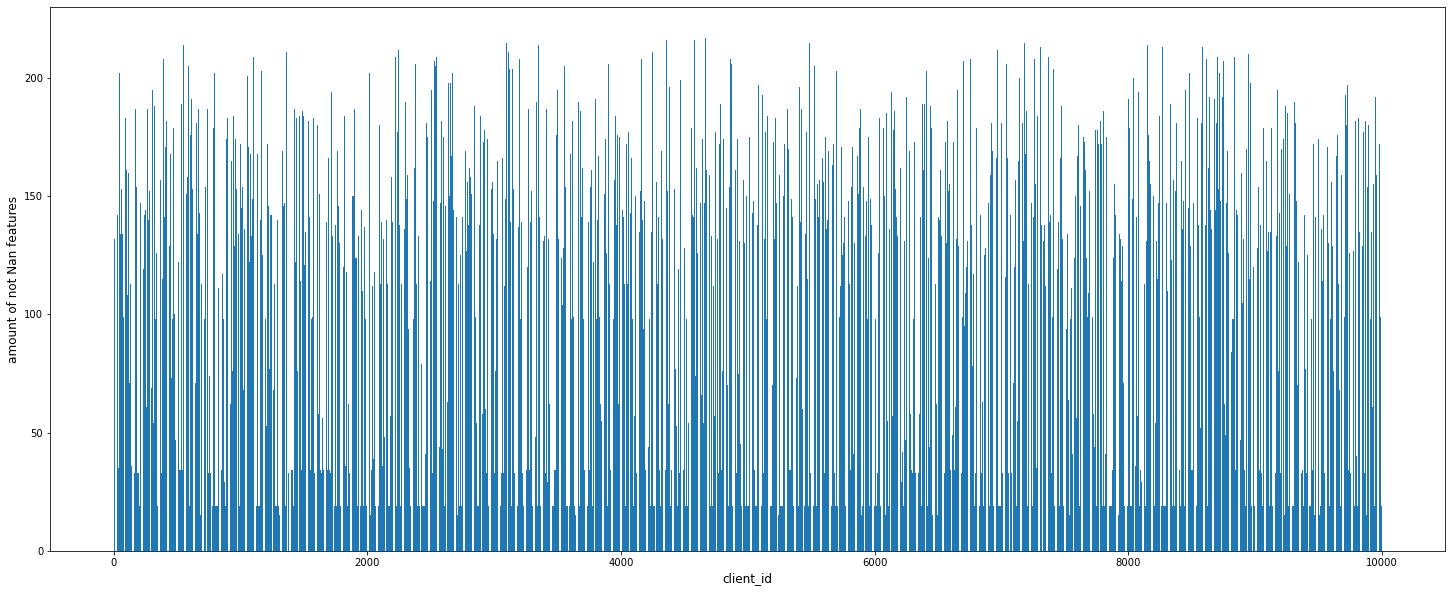

In [48]:
fig, ax = plt.subplots(1, 1,figsize=(25, 10))
ax.bar(res.index, res.values)
ax.set_xlabel('client_id', fontsize=12)
ax.set_ylabel('amount of not Nan features', fontsize=12)
plt.show()

Делаем вывод, что количество информации о каждом клиенте, которой мы владеем, отличается между клинетами достаточно сильно

**Посчитаем квантили "количества информации", имеющейся о клиентах:** 

In [49]:
np.quantile(res.values, [0.05, 0.25,0.5,0.75, 0.95])

array([ 19.,  34., 125., 162., 199.])

Таким образом, видим, что у 5-ти % пользователей, по которым мы располагаем наименьшей информацией заполнено 18 полей из 220, а среднее заполнение информации на пользователя равно 124 полям

По столбцу **report_date** видим,что информация дискретна по месяцам

**Найдем признаки, по которым меньше всего информации**

In [50]:
resFeature = aggregates.apply(lambda x: x.count(), axis =0)

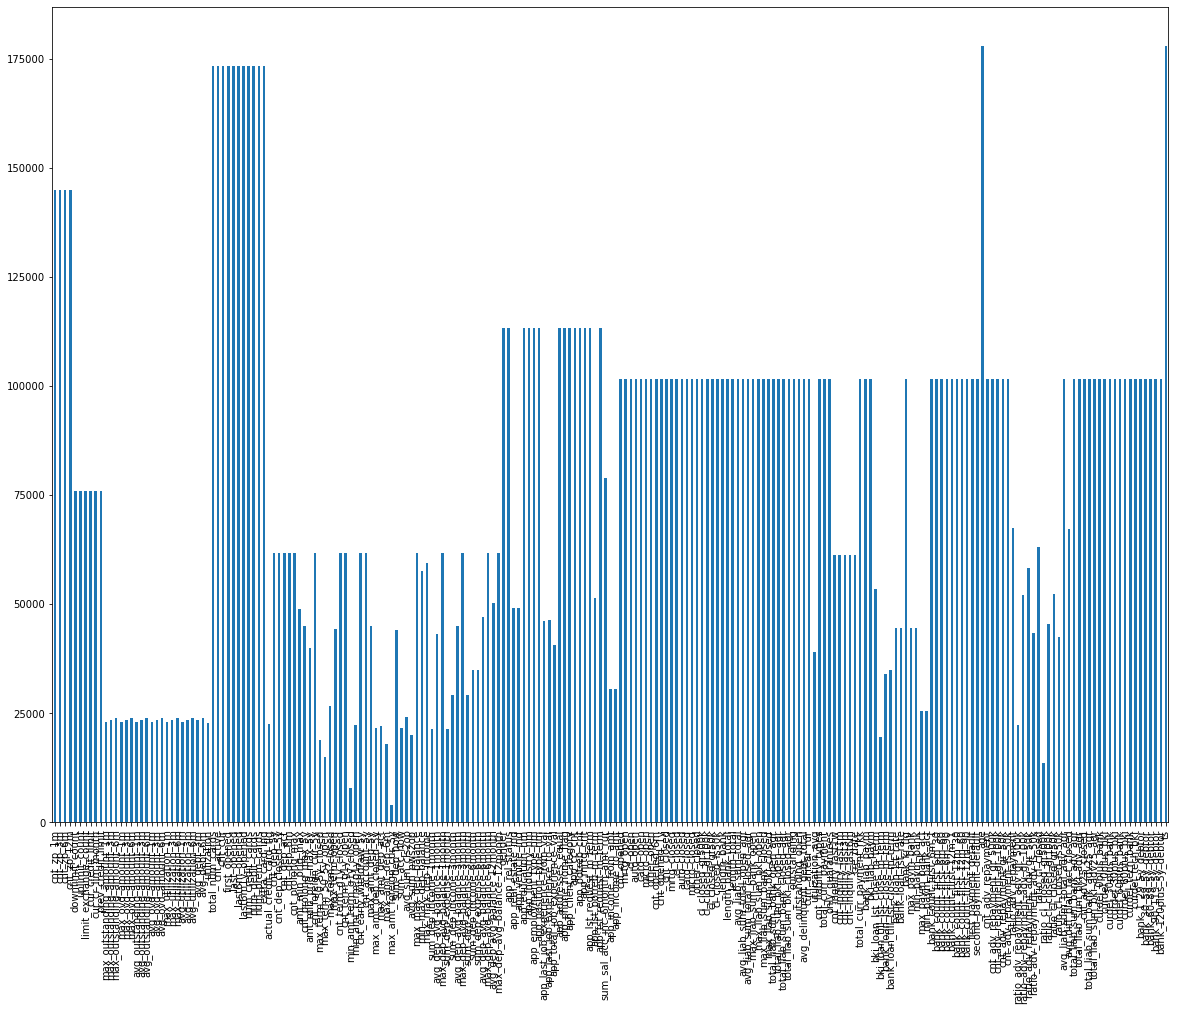

In [51]:
plot = resFeature[2:].plot
ax = plot.bar(figsize=(20,15))

**По бар плоту видим, что признаки неравномерно покрывают каждого клиента**

In [160]:
new_df = pd.merge(aggregates,transactions,  how='left', left_on=['client_id','ts'],
                  right_on = ['client_id', 'ts'])

In [163]:
new_df['mcc_group'] = new_df['mcc_group'].fillna('default')

In [110]:
aggregates.shape

(177963, 220)

In [111]:
transactions.shape

(751747, 8)

**Предобработка данных**

****Формируем таргет****


Так как необходимо выявить склонность клиента к продукту "потребительский кредит", то в качестве таргеты выберем признак *cl_open* - ***количество открытых потребительских кредитов***. Будем считать, что был открыт новый кредит, если cl_open увеличилось. Таргет будет бинарный, то есть кредит либо взят, либо нет. 

In [164]:
def append_target(df):
    serial = df['cl_open']
    shift = serial.shift()
    df['target'] = np.heaviside((serial - shift).fillna(0), 0)
    return df
    
new_df = new_df.groupby('client_id').apply(append_target)

**Работа с категориальными признаками**

In [165]:
new_df.select_dtypes(['object']).columns.to_list()

['app_rel_status',
 'app_education_nm',
 'app_industry_nm',
 'app_employment_type_nm',
 'app_position_type_nm',
 'app_client_category',
 'cre_date',
 'mcc_group']

Для обучения модели не будем использовать признаки: **сфера деятельности, категория клиента, категория клиента, дата запроса из cre, должность**

In [166]:
new_df.drop(['app_industry_nm'], inplace=True, axis=1)
new_df.drop(['app_client_category'], inplace=True, axis=1)
new_df.drop(['app_employment_type_nm'], inplace=True, axis=1)
new_df.drop(['cre_date'], inplace=True, axis=1)
new_df.drop(['app_position_type_nm'], inplace=True, axis=1)

**Преобразование признака образования**

Захешируем данные признака в виде чисел

In [167]:
dict_replace = {' ': 0,
 0: 0,
 'Неполное высшее': 1,
 'Высшее': 2,
 'Средне-специальное': 1,
 'Среднее специальное': 1,
 'Среднее': 1,
 'среднее-специальное': 1,
 'Незаконченное высшее': 1,
 'Два и более высших': 2,
 'высшее': 2,
 'Ученая степень': 2}
new_df['app_education_nm'] = new_df['app_education_nm'].map(dict_replace)
new_df['app_education_nm'] = new_df['app_education_nm'].fillna(0)

Преобразование признака **семейного положения**

Захешируем данные признаки в виде чисел

In [168]:
dict_rel_status = ({'Женат/Замужем':0, 'Холост / Не замужем':1,'Состоит в зарегистрированном браке':0,
                'Разведен/Разведена':1, 'Никогда не состоял(а) в браке':1, 'женат / замужем':0, 
                'Разведен(а) официально (развод зарегистрирован)':1, 'холост / не замужем':1, 
                'Вдовец/Вдова':1, 'в разводе':1, 'Гражданский брак':0, 'Вдовец (вдова)':1, 'Холост':1,
                'Холост/Не замужем':1, 'Женат / Замужем (брачный контракт) ':0, 'Одинокий':1, 'В разводе':1, 
                'Незамужем':1, 'вдова/вдовец':1, 'Женат':0, 'Состоит в незарегистрированном браке':0, 
                'Замужем': 0,'гражданский брак':0, 'женат / замужем (брачный контракт)':0,' ':1})

new_df['app_rel_status'] = new_df['app_rel_status'].map(dict_rel_status)
new_df['app_rel_status'] = new_df['app_rel_status'].fillna(0)

**Преобразование client_id**

In [169]:
new_df['client_id'].unique().size

9895

Уникальных клиентов много (9895), поэтому использование one-hot encoding не есть оптимальный способ представлния каотегориальных признаков. Переведем номер client_id в двличный код и тогда пространство признаков увеличится на 14, а не на 9895

In [170]:
client_id_cols = ['client_id_col_' + str(i) for i in range(14)]
list_binary= ['{0:14b}'.format(i) for i in list(new_df['client_id'])]
new_df['bin'] = [i.replace(' ', '0') for i in list_binary]
new_df[client_id_cols] = new_df['bin'].apply(list).tolist()
new_df[client_id_cols] =new_df[client_id_cols].astype(int)
new_df.pop('bin')
new_df.pop('client_id')

0         2609
1          733
2         8584
3          767
4         5900
          ... 
177958    7653
177959    3729
177960    4626
177961    7595
177962    8523
Name: client_id, Length: 177963, dtype: int64

**Нормировка данных**

In [171]:
#возраст
new_df['age'] = np.round(new_df['age'])
new_df['age'] = new_df['age']/np.mean(new_df['age'])

#доход клиента
new_df['app_income_from_amt'] = new_df['app_income_from_amt']/np.mean(new_df['app_income_from_amt'])
new_df['app_income_to_amt'] = new_df['app_income_to_amt']/np.mean(new_df['app_income_to_amt'])

new_df['ts'] = new_df['ts']/np.mean(new_df['ts'])


**Уникальные МСС группы**

In [173]:
np.unique((new_df['mcc_group']))

array(['AIRLINES', 'AUTO', 'BAR', 'BUSINESS SERVICES', 'CHARITY',
       'CLOTHING STORES', 'CONSTRUCTION SERVICES', 'EDUCATION',
       'ENTERTAINMENT', 'FINANCIAL SERVICES', 'GAMBLING',
       'GOVERNMENT SERVICES', 'HOTEL', 'LEGAL SERVICES',
       'MEDICAL SERVICES', 'NON FOOD RETAIL', 'PERSONAL SERVICES',
       'PRINTING SERVICES', 'PUBLIC SERVICE', 'REPAIR SERVICES',
       'RETAIL STORES', 'SALES BY MAIL AND PHONE', 'SERVICE PROVIDER',
       'TRANSPORTATION', 'UNCLASSIFIED PAYMENTS', 'VEHICLE RENTAL',
       'WHOLESALE', 'default', 'unknown'], dtype=object)

In [174]:
mcc_cat = pd.get_dummies(new_df.mcc_group, prefix='mcc')
new_df[mcc_cat.columns] = np.array(mcc_cat)
new_df.pop('mcc_group')

0                 default
1                 default
2                 default
3         NON FOOD RETAIL
4         CLOTHING STORES
               ...       
177958            default
177959            default
177960            default
177961            default
177962            default
Name: mcc_group, Length: 177963, dtype: object

In [175]:
new_df = new_df.fillna(0)

**Сохраним готовую таблицу**

In [176]:
new_df.to_csv('final.csv')

**Переходим к обучению модели**

In [177]:
import numpy as np
import pandas as pd
import lightgbm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import json

In [179]:
new_df['target']

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
177958    0.0
177959    0.0
177960    0.0
177961    0.0
177962    0.0
Name: target, Length: 177963, dtype: float64

In [181]:
#
# Prepare the data
#

data = pd.read_csv('final.csv')

y = data.target.values
data.drop(['target', 'Unnamed: 0',  'cl_open'], inplace=True, axis=1)

x = data.values

#
# Create training and validation sets
#
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

#
# Create the LightGBM data containers
#
train_data = lightgbm.Dataset(x_train, label=y_train)

test_data = lightgbm.Dataset(x_test, label=y_test)

#
# Train the model
#

parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

model = lightgbm.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=5000,
                       early_stopping_rounds=100)

with open("model.json", 'w') as f:
    json.dump(model.dump_model(), f)
#
# Create a submission
#


y_res_train = model.predict(x_train)
y_res_test = model.predict(x_test)

res_test = pd.DataFrame({'res_test':y_res_test, 'y_test':y_test})
res_train = pd.DataFrame({'res_train':y_res_train,'y_train':y_train})

res_test.to_csv('test.csv')
res_train.to_csv('train.csv')

[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.095970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[1]	valid_0's auc: 0.957946
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.966172
[3]	valid_0's auc: 0.968819
[4]	valid_0's auc: 0.970968
[5]	valid_0's auc: 0.972616
[6]	valid_0's auc: 0.973556
[7]	valid_0's auc: 0.974802
[8]	valid_0's auc: 0.975644
[9]	valid_0's auc: 0.976274
[10]	valid_0's auc: 0.976783
[11]	valid_0's auc: 0.977838
[12]	valid_0's auc: 0.978456
[13]	valid_0's auc: 0.978838

[258]	valid_0's auc: 0.989934
[259]	valid_0's auc: 0.989939
[260]	valid_0's auc: 0.989927
[261]	valid_0's auc: 0.989941
[262]	valid_0's auc: 0.989939
[263]	valid_0's auc: 0.98995
[264]	valid_0's auc: 0.989945
[265]	valid_0's auc: 0.989901
[266]	valid_0's auc: 0.989925
[267]	valid_0's auc: 0.989921
[268]	valid_0's auc: 0.989902
[269]	valid_0's auc: 0.989907
[270]	valid_0's auc: 0.989906
[271]	valid_0's auc: 0.989928
[272]	valid_0's auc: 0.989898
[273]	valid_0's auc: 0.9899
[274]	valid_0's auc: 0.989889
[275]	valid_0's auc: 0.989882
[276]	valid_0's auc: 0.989868
[277]	valid_0's auc: 0.989898
[278]	valid_0's auc: 0.989905
[279]	valid_0's auc: 0.989852
[280]	valid_0's auc: 0.989835
[281]	valid_0's auc: 0.989842
[282]	valid_0's auc: 0.989833
[283]	valid_0's auc: 0.989838
[284]	valid_0's auc: 0.989853
[285]	valid_0's auc: 0.989852
[286]	valid_0's auc: 0.989828
[287]	valid_0's auc: 0.989841
[288]	valid_0's auc: 0.989842
[289]	valid_0's auc: 0.989835
[290]	valid_0's auc: 0.98984
[291]	valid_0'

In [182]:
import shap
explainer = shap.Explainer(model)
shap_values = explainer(x)
#shap.plots.beeswarm(shap_values)

In [183]:
shap_values

.values =
array([[[-1.79636748e-02,  1.79636748e-02],
        [ 1.93590260e-02, -1.93590260e-02],
        [ 5.55398617e-02, -5.55398617e-02],
        ...,
        [ 5.63398107e-05, -5.63398107e-05],
        [ 1.31367558e-02, -1.31367558e-02],
        [-1.15822890e-02,  1.15822890e-02]],

       [[-1.80512889e-02,  1.80512889e-02],
        [ 1.45941646e-02, -1.45941646e-02],
        [ 5.52420247e-02, -5.52420247e-02],
        ...,
        [ 5.63398107e-05, -5.63398107e-05],
        [ 1.31367558e-02, -1.31367558e-02],
        [-7.37388881e-03,  7.37388881e-03]],

       [[ 8.26518193e-02, -8.26518193e-02],
        [ 1.11271923e-02, -1.11271923e-02],
        [-1.76636324e-02,  1.76636324e-02],
        ...,
        [ 5.63398107e-05, -5.63398107e-05],
        [ 1.31367558e-02, -1.31367558e-02],
        [-1.16377501e-02,  1.16377501e-02]],

       ...,

       [[-1.47023273e-02,  1.47023273e-02],
        [-2.84871291e-02,  2.84871291e-02],
        [ 2.42463948e-02, -2.42463948e-02],
        

In [186]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [188]:
from sklearn.metrics import f1_score

y_true_train = df_train['y_train']
y_res_train = df_train['res_train']

y_true_test = df_test['y_test']
y_res_test = df_test['res_test']

def ff(ll):
    ll_1 = ll>=0.5
    ll_1 = ll_1.astype(int)
    return ll_1
    
    
y_true_train1 = ff(y_true_train) 
y_res_train1= ff(y_res_train) 
y_true_test1= ff(y_true_test) 
y_res_test1= ff(y_res_test) 

print('f1 for train = ', f1_score(y_true_train1, y_res_train1, average='weighted'))
print('f1 for test = ', f1_score(y_true_test1, y_res_test1, average='weighted'))


f1 for train =  0.9806880907487991
f1 for test =  0.9767262912577138
